In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os
import random
from collections import Counter

# 4


In [2]:
def folder_list(path):
    filelist = os.listdir(path)
    review = []
    for infile in filelist:
        file = os.path.join(path,infile)
        r = read_data(file)
        review.append(r)
    return review
def read_data(file):
    '''
    Read each file into a list of strings. 
    Example:
    ["it's", 'a', 'curious', 'thing', "i've", 'found', 'that', 'when', 'willis', 'is', 'not', 'called', 'on', 
    ...'to', 'carry', 'the', 'whole', 'movie', "he's", 'much', 'better', 'and', 'so', 'is', 'the', 'movie']
    '''
    f = open(file)
    lines = f.read().split(' ')
    symbols = '${}()[].,:;+-*/&|<>=~" '
    words = map(lambda Element: Element.translate(str.maketrans("", "", symbols)).strip(), lines)
    words = filter(None, words)
    return list(words)
def get_data():
    pos_path = "data/pos"
    neg_path = "data/neg"
	
    pos_review = folder_list(pos_path)
    neg_review = folder_list(neg_path)
    
    review = np.array(pos_review + neg_review)
    y = 1000*[1] + 1000*[-1]
    return np.array(review), np.array(y)

def dotProduct(d1, d2):
    """
    @param dict d1: a feature vector represented by a mapping from a feature (string) to a weight (float).
    @param dict d2: same as d1
    @return float: the dot product between d1 and d2
    """
    if len(d1) < len(d2):
        return dotProduct(d2, d1)
    else:
        return sum(d1.get(f, 0) * v for f, v in d2.items())

def increment(d1, scale, d2):
    """
    Implements d1 += scale * d2 for sparse vectors.
    @param dict d1: the feature vector which is mutated.
    @param float scale
    @param dict d2: a feature vector.

    NOTE: This function does not return anything, but rather
    increments d1 in place. We do this because it is much faster to
    change elements of d1 in place than to build a new dictionary and
    return it.
    """
    for f, v in d2.items():
        d1[f] = d1.get(f, 0) + v * scale
	

In [112]:
X_all, y_all = get_data()
a = {'words': X_all, 'review': y_all}
data = pd.DataFrame(a)
data = data.sample(frac=1).reset_index(drop=True)

X_train = data[:1500]['words']
y_train = list(data[:1500]['review'])
X_val = data[1500:]['words']
y_val = list(data[1500:]['review'])

# 5

In [114]:
def bow(list1):
    return Counter(list1)
X_train = [bow(i) for i in X_train]
X_val = [bow(i) for i in X_val]

# 6.4


In [5]:
def scale(x,s):
    for i,j in x.items():
        x[i] = j*s 

In [6]:
def pegasos(X, y, lambda_ = 0.01, epoch = 10):
    num_ins = len(X)
    w = Counter()
    t = 0
    for j in range(epoch):
        for i in range(num_ins):
            t += 1
            step = 1/(t*lambda_)
            if y[i] * dotProduct(w, X[i]) < 1:
                scale(w,(1-1/t))
                increment(w,step*y[i],X[i])
            else:
                scale(w,(1-1/t))
    return w

In [204]:
%%timeit -r 1 -n 1
w = pegasos(X_train,y_train)

3min 20s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [152]:
w = pegasos(X_train,y_train,lambda_ = 0.001)

NameError: name 'util' is not defined

# 6.5

In [150]:
def pegasos_s(X, y, lambda_ = 0.01, epoch = 100):
    num_ins = len(X)
    s = 1
    W = Counter()
    t = 0
    for j in range(epoch):
        test = True
        for i in range(num_ins):
            t += 1
            step = 1/(t*lambda_)        
            if s*y[i] * dotProduct(W, X[i]) < 1:
                s = (1-1/t) * s
                if s == 0:
                    s = 1
                    W = Counter()
                else:
                    increment(W,1/s*step*y[i],X[i])
                test = False
            else:
                s = (1-1/t) * s
        if test == True:
            print('Lambda = ' + str(lambda_) + ', epoch taken = ' + str(j + 1))
            increment(W,s-1,W)
            return W
    increment(W,s-1,W)
    print('Lambda = ' + str(lambda_) + ', epoch taken = ' + str(j + 1))
    return W

In [148]:
%%timeit -r 1 -n 1 
w_s = pegasos_s(X_train,y_train, epoch = 100)

29.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [153]:
w = pegasos_s(X_train,y_train, lambda_ = 0.001)

Lambda = 0.001, epoch taken = 39


# 6.7

In [61]:
def loss_01(w, X, y):
    num_ins = len(X)
    if num_ins == 0:
        return 'No data!'
    error = 0
    for i in range(num_ins):
        if np.sign(dotProduct(X[i],w)) != np.sign(y[i]):
            error += 1
    return error/num_ins

# 6.8

In [42]:
lambda_try = [1e-8,1e-6,1e-4,1e-2,1e-1,1,10]
val_result = []
train_result = []
for i in lambda_try:
    w_s = pegasos_s(X_train,y_train, epoch = 100, lambda_ = i)
    val_result.append(loss_01(w_s, X_val, y_val))
    train_result.append(loss_01(w_s, X_train, y_train))

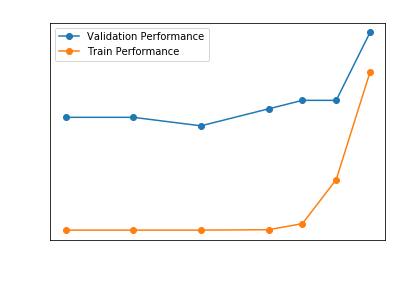

In [43]:
ax = plt.subplot()
ax.semilogx(lambda_try, val_result,'-o',label = 'Validation Performance')
ax.semilogx(lambda_try, train_result,'-o',label = 'Train Performance')
ax.legend()
ax.set_title('Performances vs Regularization Parameters', color = 'w')
ax.set_xlabel('Log Lambda', color = 'w')
ax.set_ylabel('Error Rate', color = 'w')
ax.tick_params(axis='x', colors='w')
ax.tick_params(axis='y', colors='w')

In [46]:
result_df = pd.DataFrame({'Lambda': lambda_try, 'Validation Result': val_result, 'Train Result': train_result})
result_df

,Lambda,Validation Result,Train Result
0,1.000000e-08,0.186,0.000000
1,1.000000e-06,0.186,0.000000
2,1.000000e-04,0.172,0.000000
3,1.000000e-02,0.200,0.000667
4,1.000000e-01,0.214,0.010667
5,1.000000e+00,0.214,0.083333
6,1.000000e+01,0.326,0.260667


# 7

In [141]:
w_s = pegasos_s(X_train,y_train, epoch = 100, lambda_ = 1)

In [89]:
index = list(range(500))
np.random.shuffle(index)
for i in index:
    if np.sign(dotProduct(X_val[i],w_s)) != np.sign(y_val[i]) and abs(dotProduct(X_val[i],w_s)) > 1:
        X_e = X_val[i]
        y_e = y_val[i]
        w_e = w_s
        break
print(dotProduct(X_e,w_e), y_e)

20.733333333590068 -1


In [29]:
word = []
im = []
num = []
wei = []
for key, value in X_e.items():
    word.append(key)
    im.append(abs(w_e[key] * value))
    num.append(value)
    wei.append(w_e[key])

In [30]:
contribution = pd.DataFrame({'Words' : word, 'Contribution' : im, 'Occurance' : num, 'Weight' : wei})
contribution.sort_values(by = 'Contribution', ascending= False).head(20)

,Words,Contribution,Occurance,Weight
26,the,120.133333,53,2.266667
21,and,113.333333,20,5.666667
8,scream,99.600000,18,5.533333
7,of,74.666667,35,-2.133333
62,at,44.800000,7,-6.400000
51,a,33.600000,24,-1.400000
212,as,32.000000,10,3.200000
93,in,27.200000,17,1.600000
77,out,25.400000,3,-8.466667
68,?,22.400000,7,-3.200000


In [133]:
index = list(range(500))
np.random.shuffle(index)
for i in index:
    if np.sign(dotProduct(X_val[i],w_s)) != np.sign(y_val[i]) and abs(dotProduct(X_val[i],w_s)) > 1:
        X_e = X_val[i]
        y_e = y_val[i]
        w_e = w_s
        break
print(dotProduct(X_e,w_e), y_e)
word = []
im = []
num = []
wei = []
values = []
for key, value in X_e.items():
    word.append(key)
    im.append(abs(w_e[key] * value))
    num.append(value)
    wei.append(w_e[key])
    values.append(values)
contribution = pd.DataFrame({'Words' : word, 'Contribution' : im, 'Occurance' : num, 'Weight' : wei})
contribution.sort_values(by = 'Contribution', ascending= False).head(20)

-55.73333333257142 1


,Words,Contribution,Occurance,Weight
39,on,71.466667,8,-8.933333
45,great,63.733333,4,15.933333
1,murphy,53.200000,7,-7.600000
8,and,52.800000,11,4.800000
28,the,46.933333,32,1.466667
20,to,37.600000,12,-3.133333
24,a,36.666667,22,1.666667
52,it's,33.333333,5,6.666667
254,bad,27.066667,1,-27.066667
83,one,24.600000,3,8.200000


# 6.9

In [135]:
index = list(range(500))
np.random.shuffle(index)
X_1, y_1 = [], []
X_10, y_10 = [], []
X_50, y_50 = [], []
X_100, y_100 = [], []
X_200, y_200 = [], []
for i in index:
    if abs(dotProduct(X_val[i],w_s)) < 1:
        X_1.append(X_val[i])
        y_1.append(y_val[i])
    elif abs(dotProduct(X_val[i],w_s)) >= 1 and abs(dotProduct(X_val[i],w_s)) < 10:
        X_10.append(X_val[i])
        y_10.append(y_val[i])
    elif abs(dotProduct(X_val[i],w_s)) >= 10 and abs(dotProduct(X_val[i],w_s)) < 50:
        X_50.append(X_val[i])
        y_50.append(y_val[i])
    elif abs(dotProduct(X_val[i],w_s)) >= 50 and abs(dotProduct(X_val[i],w_s)) < 100:
        X_100.append(X_val[i])
        y_100.append(y_val[i])
    else:
        X_200.append(X_val[i])
        y_200.append(y_val[i])


In [136]:
print('Value in [0,1), loss = ' + str(loss_01(w_s,X_1,y_1)))
print('Margin in [0,10), Error Rate = ' + str(loss_01(w_s,X_10,y_10)))
print('Margin in [10,50), Error Rate = ' + str(loss_01(w_s,X_50,y_50)))
print('Margin in [50,100), Error Rate = ' + str(loss_01(w_s,X_100,y_100)))
print('Margin in [100,), Error Rate = ' + str(loss_01(w_s,X_200,y_200)))

Value in [0,1), loss = 0.5
Margin in [0,10), Error Rate = 0.6666666666666666
Margin in [10,50), Error Rate = 0.3563218390804598
Margin in [50,100), Error Rate = 0.2543859649122807
Margin in [100,), Error Rate = 0.10175438596491228


# 6.10

In [145]:
index = list(range(1500))
np.random.shuffle(index)
count = 0
for i in index:
    if y_train[i]*dotProduct(X_train[i],w_s) > 0.99 and y_train[i]*dotProduct(X_train[i],w_s) < 1.01:
        count += 1
count

34

In [155]:
np.dot([1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0],[1,0,0,2,1,1,1,1,1,1,0,0,0,0,0,0,0,0,1,1,1,1,1,1])

12

In [158]:
12/(np.sqrt(22)*np.sqrt(17))

0.620505227994023